<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Long Short Term Memory (LSTM)

###Load Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.layers import Dropout

###Define Functions to Facilitate Metrics Evaluation

In [15]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [16]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/multivariate-time-series-prediction-of-crude-palm-oil-price-data-science-approach/main/cleaned_data/preprocessed.csv'
df = read_csv(path, index_col=0)
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
0,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
1,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
3,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
4,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [17]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')
del df['Date']

In [18]:
df.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Plot the Target Variable

Text(0.5, 0, 'Date')

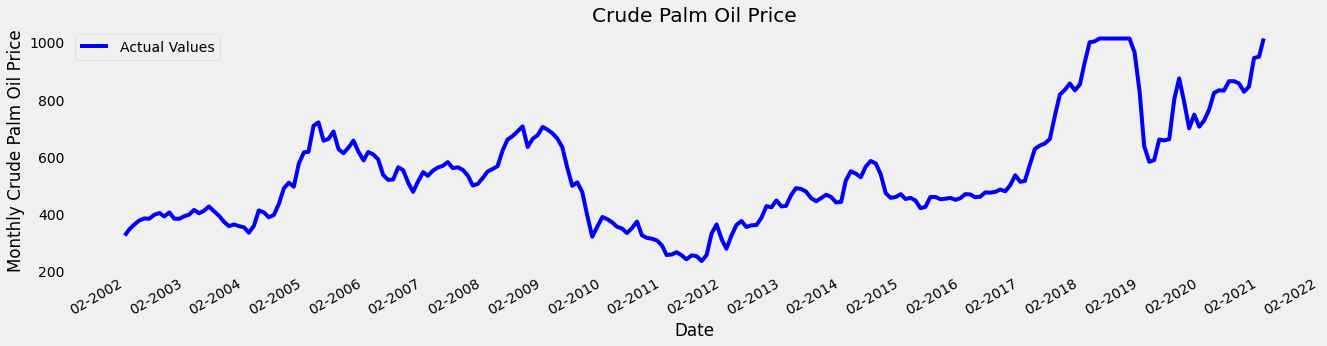

In [19]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df.index, df['cpo_pri'], color = 'blue',  label = 'Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['Actual Values', 'Crude Palm Oil Price 2002-2021'],loc='best')
plt.title('Crude Palm Oil Price')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')

###Visualize Multiple Time Series

In [20]:
fig = make_subplots(rows=6, cols=1)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cpo_pri'],name='crude palm oil price'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cno_pri'],name='coconut oil price'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['rps_pri'],name='rapeseed oil price'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['pno_pri'],name='peanut oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['sbo_pri'],name='soybean oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['wti_spri'],name='west texas intermediate spot price'),
    row=4, col=1

)
fig.update_layout(height=1000, width=1200, title_text="Time Series")
fig.show()

<Figure size 1800x720 with 0 Axes>

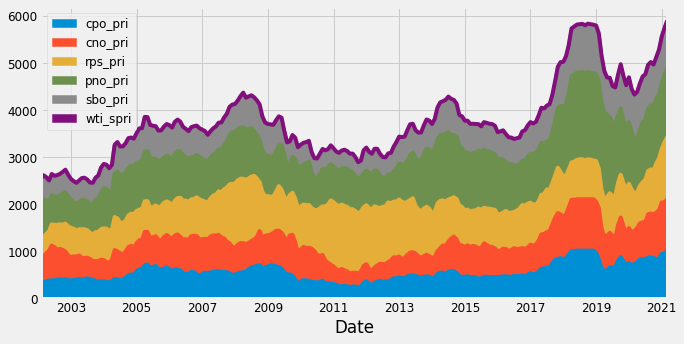

In [21]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('Date');
ax.legend(fontsize=12);

##**Long Term Short Forecasting Technique**

###**Split Data into Train Test Segments**

In [22]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 184
Test size: 46


In [23]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

184 46


In [24]:
print(train.shape)
train.head()

(184, 6)


,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Rescale train dataset

In [26]:
#f_transformer = RobustScaler()
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,0.288625,0.013238,0.323766,0.432130,0.109026
2002-03-01,345.0,0.443124,0.005303,0.272101,0.472692,0.044200
2002-04-01,362.0,0.526316,0.000000,0.179104,0.427358,0.006514
2002-05-01,376.0,0.595925,0.004228,0.059701,0.370094,0.000000
2002-06-01,383.0,0.769100,0.042041,0.065442,0.339076,0.010236


In [27]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

Date
2002-02-01    0.183505
2002-03-01    0.228866
2002-04-01    0.263918
2002-05-01    0.292784
2002-06-01    0.307216
Name: cpo_pri, dtype: float64

In [28]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2017-06-01,638.0,0.757216,0.455910,0.585121,0.979313,0.431141
2017-07-01,645.0,0.811545,0.517005,0.521619,1.021570,0.442463
2017-08-01,661.0,0.821732,0.485027,0.566257,1.031090,0.384150
2017-09-01,743.0,0.921902,0.482428,0.592618,1.113813,0.403381
2017-10-01,816.0,1.033956,0.507880,0.697371,1.197323,0.345068


In [29]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

Date
2017-06-01    0.832990
2017-07-01    0.847423
2017-08-01    0.880412
2017-09-01    1.049485
2017-10-01    1.200000
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [30]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(181, 3, 6) (181,)


###Create Model

####Declare input shape

In [33]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(tf.keras.layers.Dropout(rate=0.2))
lstm_model.add(tf.keras.layers.Dense(units=1))
lstm_model.compile(loss='mse', optimizer='adam')

In [34]:
lstm_history = lstm_model.fit(X_train, y_train,epochs=50,batch_size=32,validation_split=0.1,shuffle=False)

Epoch 1/50
6/6 [==============================] - 4s 120ms/step - loss: 0.2300 - val_loss: 0.0831
Epoch 2/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0679 - val_loss: 0.0079
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0392 - val_loss: 0.0152
Epoch 4/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0363 - val_loss: 0.0094
Epoch 5/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0227 - val_loss: 0.0061
Epoch 6/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0211 - val_loss: 0.0078
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0239 - val_loss: 0.0060
Epoch 8/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0178 - val_loss: 0.0048
Epoch 9/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0148 - val_loss: 0.0052
Epoch 10/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0132 - val_loss: 0.0045
Epoch 11/50
6/6 [===========

dict_keys(['loss', 'val_loss'])


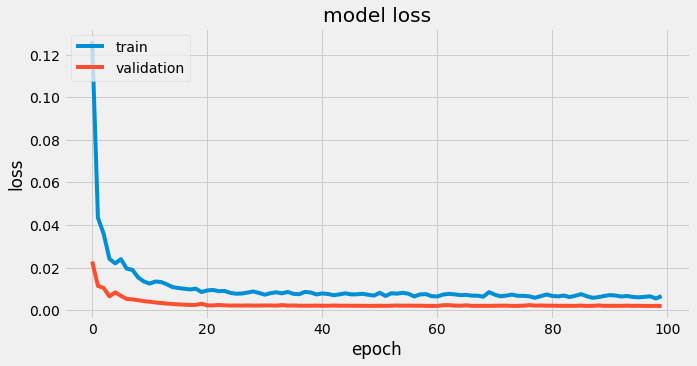

In [40]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###Model Summary

In [41]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               69120     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,249
Trainable params: 69,249
Non-trainable params: 0
_________________________________________________________________


###Predict the Test Data

In [42]:
y_pred = lstm_model.predict(X_test)
y_pred

array([[0.89715743],
       [0.96165144],
       [1.0643742 ],
       [1.1909196 ],
       [1.2878919 ],
       [1.3370221 ],
       [1.3878675 ],
       [1.4452804 ],
       [1.5384616 ],
       [1.5979166 ],
       [1.6274279 ],
       [1.6342745 ],
       [1.6410518 ],
       [1.6423249 ],
       [1.6423101 ],
       [1.6389301 ],
       [1.6374092 ],
       [1.6153908 ],
       [1.5242436 ],
       [1.3230203 ],
       [1.0758832 ],
       [0.8918348 ],
       [0.8500092 ],
       [0.8748132 ],
       [0.92358875],
       [0.99008435],
       [1.1477764 ],
       [1.2943627 ],
       [1.2792236 ],
       [1.2146735 ],
       [1.1635604 ],
       [1.1919332 ],
       [1.2056191 ],
       [1.2997676 ],
       [1.3690221 ],
       [1.3949797 ],
       [1.3935847 ],
       [1.3988291 ],
       [1.3989395 ],
       [1.3663794 ],
       [1.3480093 ],
       [1.4205372 ],
       [1.5376736 ]], dtype=float32)

In [43]:
y_pred.reshape(1,-1)

array([[0.89715743, 0.96165144, 1.0643742 , 1.1909196 , 1.2878919 ,
        1.3370221 , 1.3878675 , 1.4452804 , 1.5384616 , 1.5979166 ,
        1.6274279 , 1.6342745 , 1.6410518 , 1.6423249 , 1.6423101 ,
        1.6389301 , 1.6374092 , 1.6153908 , 1.5242436 , 1.3230203 ,
        1.0758832 , 0.8918348 , 0.8500092 , 0.8748132 , 0.92358875,
        0.99008435, 1.1477764 , 1.2943627 , 1.2792236 , 1.2146735 ,
        1.1635604 , 1.1919332 , 1.2056191 , 1.2997676 , 1.3690221 ,
        1.3949797 , 1.3935847 , 1.3988291 , 1.3989395 , 1.3663794 ,
        1.3480093 , 1.4205372 , 1.5376736 ]], dtype=float32)

###Invert Transformed Data

In [44]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370. 354. 348.
  332. 349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254.
  251. 234. 255. 330. 362. 310. 277. 323. 360. 374. 353. 359. 360. 385.
  426. 422. 446. 425. 427. 465. 489. 486. 477. 454. 443. 454. 466. 458.
  439. 441. 515. 548. 540. 527. 564. 584. 575. 537. 471. 455. 458. 468.
  451. 455. 446. 419. 423. 458. 458. 450. 452. 455. 448. 454. 468. 467.
  457. 459. 474. 473. 476. 484. 478. 499. 534. 511. 514. 572. 626.]]
[[ 743.    816.    833.    855.    831.    852.    926.    999.   1

###Plot History, Actual and Predicted Value

In [45]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370., 354., 348., 332.,
       349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.,
       374., 353., 359., 360., 385., 426., 422., 446., 425., 427., 465.,
       489., 486., 477., 454., 443., 454., 466., 458., 439., 441., 515.,
       548., 540., 527., 564., 584., 575., 537., 47

In [46]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([ 743.  ,  816.  ,  833.  ,  855.  ,  831.  ,  852.  ,  926.  ,
        999.  , 1002.  , 1012.25, 1012.25, 1012.25, 1012.25, 1012.25,
       1012.25, 1012.25,  964.  ,  826.  ,  636.  ,  581.  ,  587.  ,
        659.  ,  656.  ,  660.  ,  800.  ,  873.  ,  789.  ,  698.  ,
        746.  ,  704.  ,  725.  ,  763.  ,  822.  ,  831.  ,  830.  ,
        863.  ,  863.  ,  855.  ,  826.  ,  844.  ,  944.  ,  949.  ,
       1012.25])

In [47]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([ 669.12134,  700.40094,  750.2215 ,  811.596  ,  858.62756,
        882.4557 ,  907.1157 ,  934.961  ,  980.1539 , 1008.9896 ,
       1023.30255, 1026.6232 , 1029.9102 , 1030.5276 , 1030.5205 ,
       1028.8811 , 1028.1436 , 1017.4646 ,  973.2582 ,  875.66486,
        755.80334,  666.5399 ,  646.25446,  658.28436,  681.94055,
        714.1909 ,  790.6715 ,  861.76587,  854.4234 ,  823.11664,
        798.3268 ,  812.0876 ,  818.7253 ,  864.38727,  897.9757 ,
        910.5651 ,  909.8886 ,  912.4321 ,  912.48566,  896.694  ,
        887.78455,  922.9606 ,  979.77167], dtype=float32)

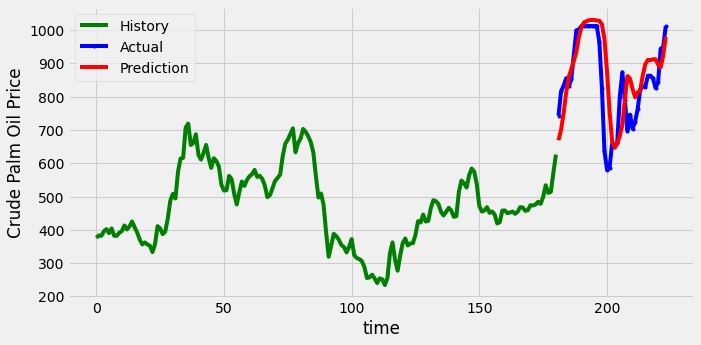

In [48]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('time')
plt.legend()
plt.show();

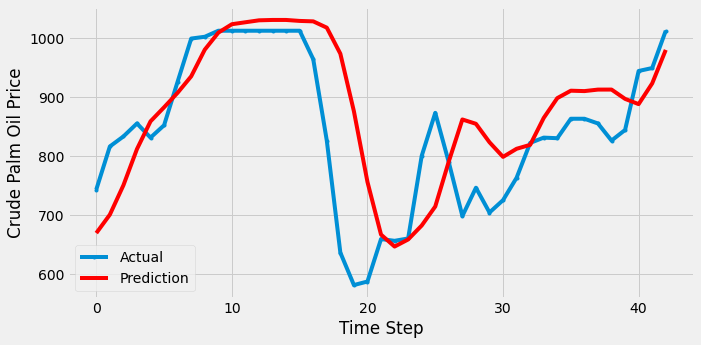

In [49]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

###Evaluate LSTM Model Accuracy

In [50]:
MAE_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the SVR Model is:', MAE_lstm)

MDA_lstm = mda(y_test_inv, y_pred_inv)
print('MDA value of the SVR Model is:', MDA_lstm)

MAPE_lstm = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the SVR Model is:', MAPE_lstm)

RMSE_lstm = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the SVR Model is:', RMSE_lstm)

MSE_lstm = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the SVR Model is:', MSE_lstm)

EVS_lstm = explained_variance_score(y_test_inv, y_pred_inv)
print('EVS score of the MLP Model is:', EVS_lstm)

MAE value of the SVR Model is: 68.74582973746367
MDA value of the SVR Model is: 0.5476190476190477
MAPE value of the SVR Model is: 9.191241816135435
RMSE value of the SVR Model is: 100.480008642795
MSE value of the SVR Model is: 10096.232136856159
EVS score of the MLP Model is: 0.42768331420988737


In [ ]:
...updating